In [87]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

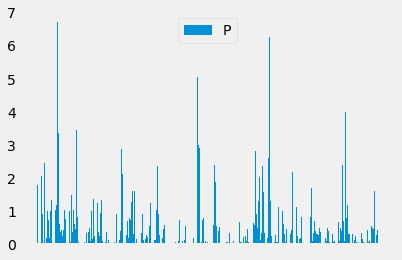

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
dates = session.query(Measurement.date).all()


# Calculate the date 1 year ago from the last data point in the database
dates = pd.DataFrame(dates)
dates['date'] = pd.to_datetime(dates['date'], format='%Y-%m-%d')
#dates['date'] = dt.date(dates['date'], '%Y-%m-%d')
new_date = dates['date'].max() - dt.timedelta(days=365)
new_date = new_date.date()
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= str(new_date)).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = pd.DataFrame(prcp)
prcp.set_index('date')
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prcp['date'], prcp['prcp'])
plt.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)
plt.legend('Precipitation', loc=9)
plt.grid()



![precipitation](Images/precipitation.png)

In [117]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [93]:
# Design a query to show how many stations are available in this dataset?
#session.query(Station.station).count()
session.query(Station.station).all()


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
              func.avg(Measurement.tobs)).all()

[(53.0, 87.0, 73.09795396419437)]

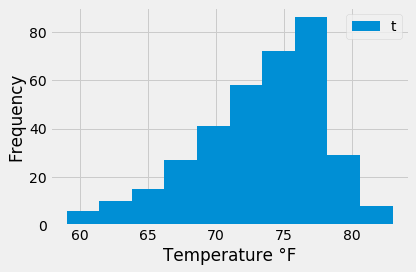

In [88]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281')\
    .filter(Measurement.date >= str(new_date)).all()
temps = pd.DataFrame(temps)
plt.hist(temps['tobs'])
plt.ylabel('Frequency')
plt.legend('tobs')
plt.xlabel('Temperature °F')
plt.tight_layout()


![precipitation](Images/station-histogram.png)

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps(new_date, dates['date'].max().date())

[(58.0, 74.59058295964125, 87.0)]

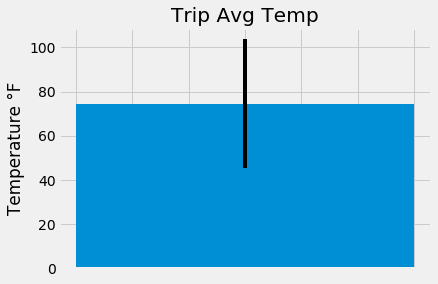

In [92]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg = calc_temps(new_date, dates['date'].max().date())
yerr = avg[0][2] - avg[0][0]
avg[0][1]
plt.bar(1, avg[0][1], yerr = yerr)
plt.tight_layout()
plt.title("Trip Avg Temp")
plt.ylabel("Temperature °F")
plt.tick_params(axis='x',which='both', bottom=False, top=False, labelbottom=False)

In [84]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station, Station.name, Station.latitude, Station.longitude,\
              Station.elevation, func.sum(Measurement.prcp)).\
    join(Measurement, Station.station==Measurement.station).filter(Measurement.date >= str(new_date)).\
    group_by(Station.station, Station.name, Station.latitude, Station.longitude,\
              Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.81000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  70.03000000000003),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.510000000000026),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  38.01),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.239999999999995),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


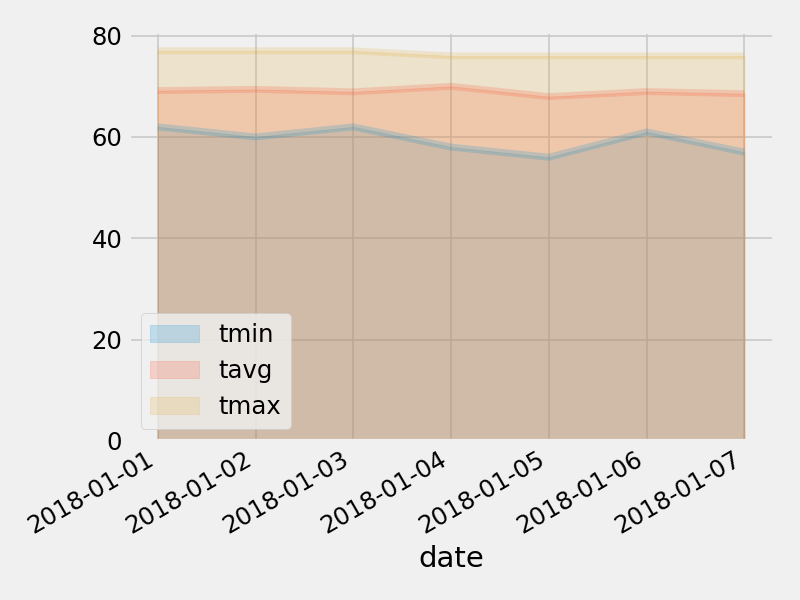

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
